## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_108.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(86917, 10)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220401]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI'],
      dtype='object')

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [4]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret 'alpha_atr' 'alpha_kama' 'alpha_009' 'alpha_AI' 
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 260/260 [00:02<00:00, 92.42it/s]


### Rescale AI Factor

In [5]:
def rescale_(data):
    # resize from -1 to 1
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    max_val = data[feature].median() + 3.5*data[feature].std()
    min_val = data[feature].median() - 3.5*data[feature].std()
    data[feature] = np.where(data[feature]>max_val, max_val, 
                           np.where(data[feature]<min_val, min_val, data[feature]))
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                             np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

# need to fix excuted in privious step
def zscore_AI(data):
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

#universe_z = universe.groupby('trade_date').apply(rescale_)
universe_z = universe.groupby('trade_date')[universe.columns].apply(rescale_)

0.07772891


<AxesSubplot:>

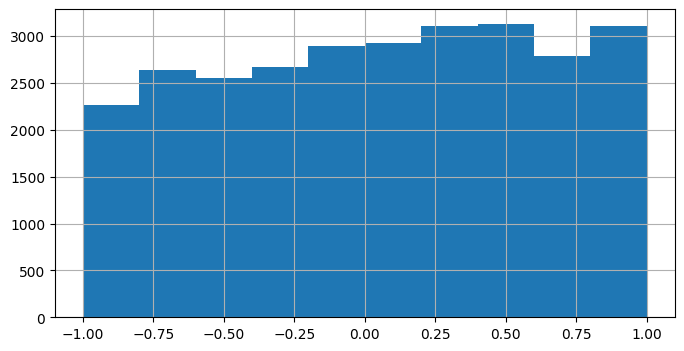

In [6]:
print(universe_z['alpha_AI'].median())
universe_z['alpha_AI'].hist()

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [7]:
## shif return 5 days
all_factors = universe_z.copy(deep=True)
#all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-2)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['trade_date', 'ts_code'])
print(universe.shape, all_factors.shape)

(28080, 10) (28080, 11)


In [8]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr     0.005818
alpha_kama    0.013511
alpha_009     0.009974
alpha_AI      0.000974
dtype: float64

In [411]:
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

start_time = 20220501
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df['trade_date']>=start_time]
calendar = alpha_df.trade_date.unique() # int64

# only for positive estimate
# for feature in alpha_field:
#     alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 241/241 [00:05<00:00, 43.67it/s]


alpha_atr     0.0
alpha_kama    0.0
alpha_009     0.0
alpha_AI      0.0
dtype: float64

#### Veiw Factor Returns

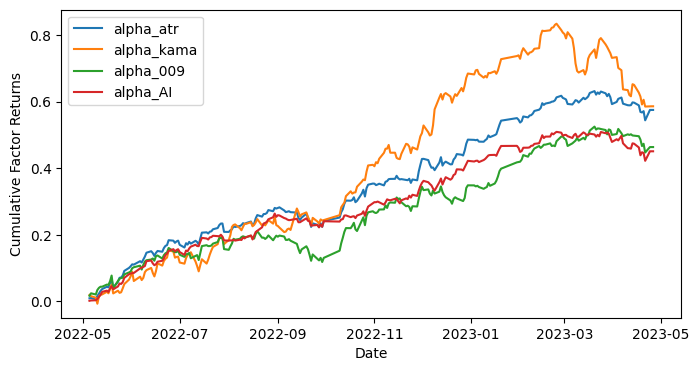

In [412]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [11]:
universe = universe.loc[universe['trade_date']>=20220401]
all_factors = all_factors.loc[all_factors['trade_date']>=20220401]

In [12]:
all_factors.tail()

,ts_code,trade_date,name,industry,close,log-ret,alpha_atr,alpha_kama,alpha_009,alpha_AI,returns_2
date,,,,,,,,,,,
2023-04-26,688358.SH,20230426,祥生医疗,医疗保健,48.41,-0.129988,-0.564220,-0.016731,0.339945,-0.808847,0.0
2023-04-26,688579.SH,20230426,山大地纬,软件服务,14.81,-0.042953,0.169209,0.032989,-0.770691,-0.410884,0.0
2023-04-26,688589.SH,20230426,力合微,半导体,44.20,0.006127,-0.214198,0.016049,0.096292,-0.526331,0.0
2023-04-26,688655.SH,20230426,迅捷兴,元器件,12.08,0.001657,0.756325,0.048255,-0.922845,0.957242,0.0
2023-04-26,688799.SH,20230426,华纳药厂,化学制药,40.49,0.041862,0.077932,0.043051,0.012775,-0.061502,0.0


### PCA model
We use PCA algorithm to estimate risk

In [13]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=250):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [14]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
#     for col in returns_df.columns:
#         returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 5
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 19
return date 20220505


ts_code,000411.SZ,000756.SZ,000915.SZ,002322.SZ,002362.SZ,002365.SZ,002380.SZ,002462.SZ,002577.SZ,002605.SZ,...,688230.SH,688244.SH,688259.SH,688314.SH,688317.SH,688358.SH,688579.SH,688589.SH,688655.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000411.SZ,0.386088,0.314893,0.282795,0.219332,0.211240,0.277514,0.155900,0.238088,0.235335,0.265091,...,0.325587,0.0,0.164100,0.213170,0.345477,0.214029,0.255498,0.326390,0.312304,0.199060
000756.SZ,0.314893,1.136972,0.299495,0.136559,0.182113,0.268407,0.041688,0.308033,0.213835,0.163146,...,0.217948,0.0,0.082208,0.190131,0.113740,0.111284,0.198284,0.306871,0.102795,0.144325
000915.SZ,0.282795,0.299495,0.469198,0.199641,0.191572,0.245194,0.148152,0.184545,0.209714,0.227681,...,0.299648,0.0,0.165894,0.202693,0.298703,0.186625,0.226514,0.322496,0.285710,0.167925
002322.SZ,0.219332,0.136559,0.199641,0.258088,0.151007,0.214021,0.129198,0.147243,0.174276,0.200596,...,0.248064,0.0,0.131661,0.151965,0.282998,0.171115,0.192161,0.221266,0.261694,0.144197
002362.SZ,0.211240,0.182113,0.191572,0.151007,0.180548,0.153217,0.109382,0.148013,0.149535,0.166406,...,0.225680,0.0,0.126237,0.143842,0.231833,0.150299,0.184186,0.234771,0.234251,0.123976


In [15]:
risk_fr.iloc[-5,:]

0    0.125699
1    0.361319
2    0.267868
3   -0.036192
4   -0.080879
Name: 20220426, dtype: float64

In [16]:
h=np.array([1e4]*108) 
(np.dot(h, variance_i).dot(h.T))** 0.5

497679.66964679904

In [17]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:]]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 19
(26028, 3) (26028, 12)


### Calculate Risk Factor Returns

In [18]:
## calculate risk factor return module
def change_risk_B_col(B):
    new_colnames = ['risk_' + str(_) for _ in B.columns if 'risk_' not in str(_)]
    if len(new_colnames) == 0:
        return B
    B_columns_map = {}
    for i, col in enumerate(B.columns):
        B_columns_map[col] = new_colnames[i]
    B = B.rename(columns=B_columns_map)
    return B

tmp = all_factors.loc[all_factors['trade_date']==20220601].sort_values(by=['ts_code'])
B = change_risk_B_col(B)
B.index.name='ts_code'
tmp = tmp.merge(B.reset_index(), on=['ts_code'], how='left')
estimate_factor_returns(tmp, name='risk_')

risk_0   -0.212161
risk_1   -0.044381
risk_2    0.041622
risk_3    0.008896
risk_4   -0.027319
dtype: float64

In [19]:
for dt in tqdm(calendar, desc='regression risk returns'):
    tmp = all_factors.loc[all_factors['trade_date']==dt].sort_values(by=['ts_code'])
    B = variance_all[dt][1]
    B = change_risk_B_col(B)
    B.index.name='ts_code'
    tmp = tmp.merge(B.reset_index(), on=['ts_code'], how='left')
    facotr_return = estimate_factor_returns(tmp, name='risk_')
    variance_all[dt][2]=facotr_return

#variance_all[calendar[-1]][2]

regression risk returns: 100%|████████████████| 241/241 [00:07<00:00, 34.12it/s]


### (Optional) Store Residual

In [20]:
#universe = universe.merge(residual_df, on=['ts_code', 'trade_date'], how='left')
#universe = universe.rename(columns={'residual': 'alpha_resi'})
#universe = universe.loc[universe['trade_date']>=start_time]

In [21]:
#universe['alpha_resi'].hist()

In [22]:
# universe['alpha_resi'] = universe['alpha_resi'] * 1000
# universe.to_csv('AI_data/factors_AI_108_residual.csv')

### Combine Factors

In [647]:
#'alpha_atr14', 'alpha_kama', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['ts_code'])
#alpha_df['alpha_all'] = alpha_df['alpha_kama']
alpha_df['alpha_all'] = 0.6*alpha_df['alpha_atr'] + 0.4*alpha_df['alpha_kama']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0 -1.0


In [648]:
# for dt in alpha_df.trade_date.unique():
#     tmp = alpha_df.loc[alpha_df.trade_date==dt]
#     print(tmp.name)

### Backtest by Convex Optimization
- use `scipy.optimize.fmin_l_bfgs_b` top optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk rescale weights

In [651]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * (np.dot(h, variance).dot(h.T)) \
             + np.dot((h-h0)**2, Lambda) 
             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) 
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220601
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0, 10000)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal

409247.46714556345 39292.5333967099
182177.77672549224 169617.28521784922


<AxesSubplot:>

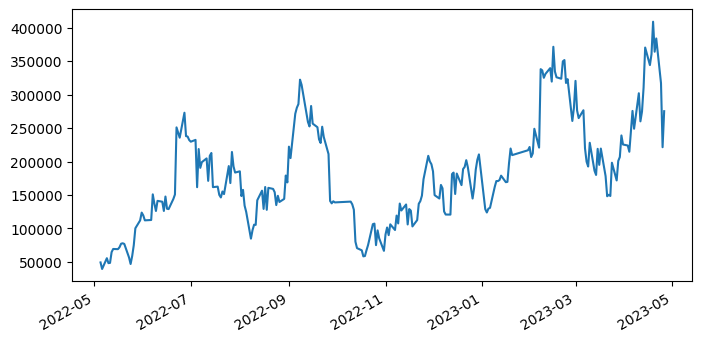

In [652]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [653]:
rescale_weight = 2
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt']/rescale_weight
    positions[i]['h_privious'] = positions[i]['h_privious']/rescale_weight

h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [654]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

204623.73357278173 19646.26669835495


137681.06982748912 (19, 13)


name  close   log-ret   h_privious   h_opt
date       ts_code                                              
2023-04-26 000411.SZ  英特集团  11.60  0.009528  5000.000000  5000.0
           000915.SZ  华特达因  35.48  0.011338  5000.000000  5000.0
           002322.SZ  理工能科  10.30  0.004866  5000.000000  5000.0
           002365.SZ  永安药业  10.41  0.018420  5000.000000  5000.0
           002462.SZ   嘉事堂  15.53  0.025433  5000.000000  5000.0
           002788.SZ  鹭燕医药   9.13  0.024391  5000.000000  5000.0
           002923.SZ  润都股份  18.21  0.009934  5000.000000  5000.0
           300233.SZ  金城医药  20.07  0.023187  5000.000000  5000.0
           300463.SZ  迈克生物  16.13  0.008092  5000.000000  5000.0
           300485.SZ  赛升药业  10.88  0.019490  5000.000000  5000.0
           300532.SZ  今天国际  18.88 -0.011585  5000.000000  5000.0
           300636.SZ  同和药业  13.42  0.032566  5000.000000  5000.0
           600513.SH  联环药业  10.49  0.010542  5000.000000  5000.0
           600750.SH  江中药业  22.01 -0.045301  5000.000000  5000.0
           603102.SH  百合股份  45.67  0.052827  5000.000000  5000.0
           603351.SH  威尔药业  23.99  0.016390  5000.000000  5000.0
           603386.SH  骏亚科技  11.13 -0.029219  5000.000000  5000.0
           603538.SH   美诺华  22.75  0.010605  3019.132968  5000.0
           688317.SH  之江生物  28.80  0.000000     0.000000  5000.0

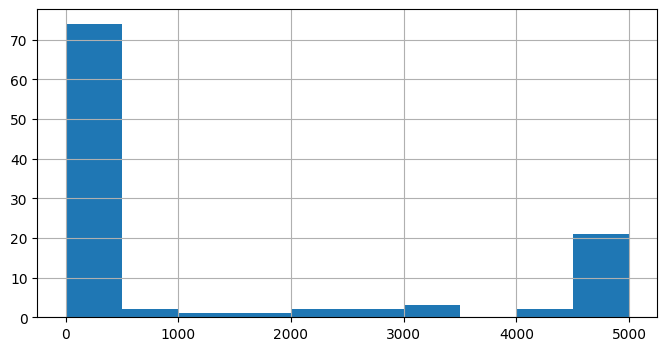

In [668]:
date_hold = 20230426
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[positions[date_hold]['h_opt']>=5000]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['name', 'close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

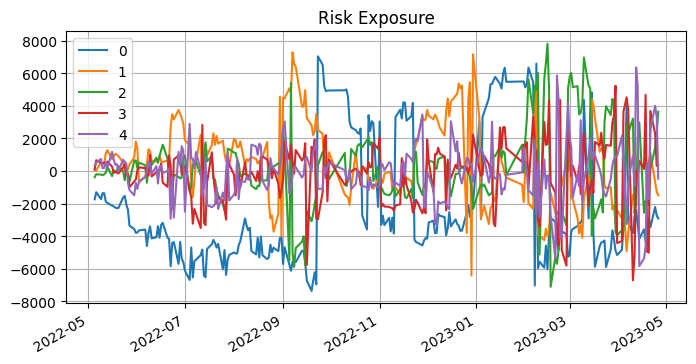

In [658]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

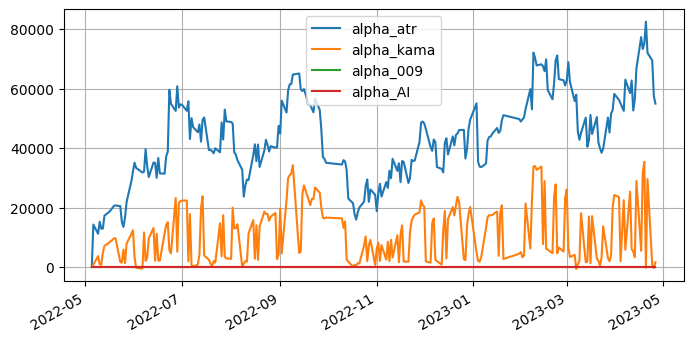

In [661]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0.7, 0.3, 0.0, 0.0]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

8486.398300157955 -5000.0


<AxesSubplot:>

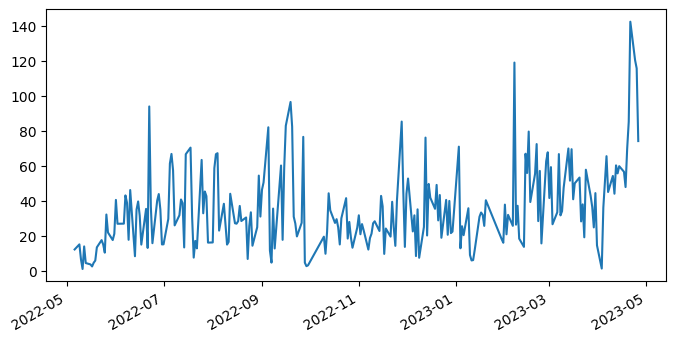

In [662]:
transaction_costs = []
retre_max = 0
Lambda = 3e-6
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    if min(tmp_change)<retre_max:
        retre_max = min(tmp_change)
    costs = sum(np.dot(tmp_change**2, Lambda)**0.5)
    transaction_costs.append(costs)
print(sum(transaction_costs),retre_max)
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Cal BenchMark

In [663]:
benchmark_return = pd.read_csv('AI_data/benmark_AI_108.csv')
benchmark_return.columns = ['trade_date', 'log-ret']
benchmark_return.tail()

,trade_date,log-ret
984,20230420,0.006796
985,20230421,-0.023961
986,20230424,0.001652
987,20230425,-0.018656
988,20230426,-0.011628


### Profit-and-Loss (PnL)

2023-04-20 00:00:00


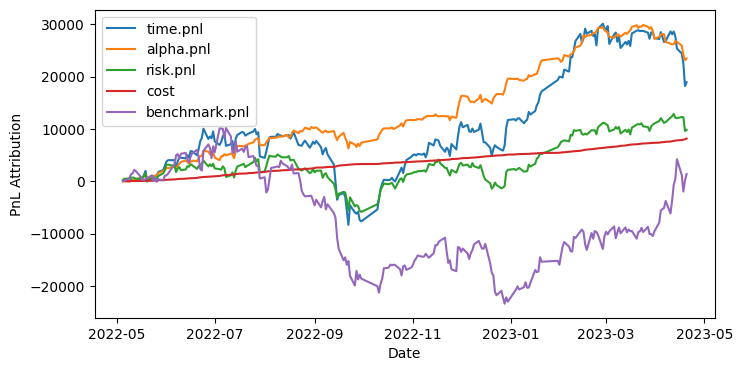

In [664]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)
        df.at[time_i,"cost"] = transaction_costs[ii]
        df.at[time_i,"benchmark.pnl"] = positions[dt]['h_opt'].sum() * \
                            benchmark_return.loc[benchmark_return.trade_date==dt]['log-ret'].values[0]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [665]:
attr['time.pnl'].sum()

18925.59298558357

In [666]:
attr['time.pnl'].cumsum().min()

-8327.411483666909

In [667]:
attr['benchmark.pnl'].sum()

1379.93306974203